# Interactive plots

This notebook show how to use `Holoviews` based plotting methods to create interactive plots of the magnetisation or derived quantities. The interface is the same as in `discretisedfield.Field.hv`. For details on the different plotting methods refer to the documentation of `Holoviews` based plotting in `discretisedfield`.

In [1]:
import os

import discretisedfield as df

import micromagneticdata as md

We have a set of example simulations stored in the test directory of `micromagneticdata` that we use to demonstrate its functionality.

In [2]:
dirname = os.path.join("..", "micromagneticdata", "tests", "test_sample")

## `Data`
First, we creata a `Data` object. We need to pass the name of the `micromagneticmodel.System` that we used to run the simulation and optionally an additional path to the base directory.

In [3]:
data = md.Data(name="system_name", dirname=dirname)

The `Data` object contains all simulation runs of the `System`. These are called drives.

In [4]:
data.info

drive_number        date      time            driver             t     n  \
0             0  2022-02-11  12:51:44        TimeDriver  2.500000e-11  25.0   
1             1  2022-02-11  12:51:45        TimeDriver  1.500000e-11  15.0   
2             2  2022-02-11  12:51:45        TimeDriver  5.000000e-12  10.0   
3             3  2022-02-11  12:51:46         MinDriver           NaN   NaN   
4             4  2022-02-11  12:51:46        TimeDriver  5.000000e-12   5.0   
5             5  2022-02-11  12:51:46         MinDriver           NaN   NaN   
6             6  2022-02-11  12:51:47  HysteresisDriver           NaN  21.0   
7             7  2022-06-19  16:15:06       RelaxDriver           NaN   NaN   
8             8  2022-06-19  16:15:07         MinDriver           NaN   NaN   
9             9  2022-06-19  16:15:08        TimeDriver  5.000000e-09  10.0   

                Hmin                Hmax  
0                NaN                 NaN  
1                NaN                 NaN  
2                NaN                 NaN  
3                NaN                 NaN  
4                NaN                 NaN  
5                NaN                 NaN  
6  [0, 0, 1000000.0]  [0, 0, -1000000.0]  
7                NaN                 NaN  
8                NaN                 NaN  
9                NaN                 NaN

## Time evolution of the magnetisation

In [5]:
time_drive = data[1]

We first create a plot for the averaged magnetisation components to better understand the behaviour of the system. We can see a precession of all three components of the averaged magnetisation.

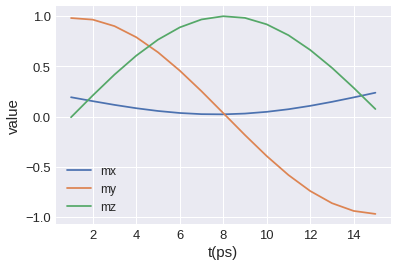

In [6]:
time_drive.table.mpl(y=["mx", "my", "mz"])

We can use the `.hv` convenience method to create a plot similar to the plotting functionality in `discretisedfield`. We get an additional slider for the time variable.

In [7]:
time_drive.hv(
    kdims=["x", "y"],
    vdims=["x", "y"],
    scalar_kw={"clim": (-800000, 800000), "cmap": "coolwarm"},
)

:DynamicMap   [t,z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

We see that the magnetisation direction per time-step is uniform throughout the sample.

In [8]:
time_drive.hv(
    kdims=["y", "z"],
    vdims=["y", "z"],
    scalar_kw={"clim": (-800000, 800000), "cmap": "cividis"},
)

:DynamicMap   [t,x]
   :Overlay
      .Image.I       :Image   [y,z]   (field)
      .VectorField.I :VectorField   [y,z]   (angle,mag)

Resampling can be done like in `discretisedfield` using a tuple (to only affect `kdims`) or a dictionary to affect arbitrary dimensions. Here we reduce the number of points of the scalar part only in `t` direction and the number of arrows/the vector part in `x`, `y`, and `t` direction. We have to make sure that the same number of points are used for the scalar and vector part of the plot.

In [9]:
time_drive.hv(
    kdims=["x", "y"],
    vdims=["x", "y"],
    scalar_kw={"clim": (-800000, 800000), "cmap": "coolwarm", "n": {"t": 10}},
    vector_kw={"n": {"x": 10, "y": 6, "t": 10}},
)

:DynamicMap   [t,z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

## Computing derived quantities

If we want to first compute something for each field and then plot the result we have to use the following code snippet. Here, we plot the normalised magnetisation instead of the full magnetisation.

In [10]:
import xarray as xr

First we compute the desired quantity for each field and save `xarray.DataArrays` of the resulting `Field` objects.

In [11]:
normalised_fields = []
for field in time_drive:
    normalised_fields.append(field.orientation.to_xarray())

Then we can use `xarray` to concatenate the results along the time dimension `t`. This dimension (the independent variable of the drive) can be accessed as `time_drive.x`. To get coordinates of that dimension we can use the `table` object of the drive.

In [12]:
normalised = xr.concat(normalised_fields, dim=time_drive.table.data[time_drive.x])

We can then use the `Holoviews` based plotting methods. These are part of discretisedfield. Here, we plot the resulting data over t and x. We create a scalar plot and get a drop-dow selection for the individual components. We can see that the magnetisation per time step is uniform througout spatial x (and y and z) and changes over time.

We have to change the aspect of the plot `data_aspect` to get a proper plot. We use the ratio of the plot x direction (time) and the plot y direction (spatial x coordinate).

In [13]:
df.plotting.Hv(normalised).scalar(kdims=["t", "x"]).opts(data_aspect=1e-4)

:DynamicMap   [comp,z,y]
   :Image   [t,x]   (field)

To give a second example, we compute the topological charge density on xy planes. This operation is implemented in `discretisedfield.tools`. However, `discretisedfield.tools.topological_charge_density` can only work on a single plane. Therefore, we compute the `emergent_magnetic_field` and take the `x` component (which gives the topolical charge on xy planes). As the magnetisation is uniform throughout the sample the topological charge density is zero everywhere (rendering this example somewhat boring). To still see the resulting data we have to use `norm_filter=False` when creating the plot.

In [14]:
import discretisedfield.tools as dft

In [15]:
tcd_fields = []
for field in time_drive:
    tcd_fields.append(dft.emergent_magnetic_field(field).x.to_xarray())
tcd = xr.concat(tcd_fields, dim=time_drive.table.data[time_drive.x])
df.plotting.Hv(tcd)(kdims=["x", "y"], norm_filter=False)

:DynamicMap   [t,z]
   :Image   [x,y]   (field)